# Econ 281: Computational Tools in Macroeconomics

### Homework 5: Extension of Aiyagari (1994)

##### Youngdoo Choi (yoc005@ucsd.edu), May 2024

---

### Task 1: Replicate Aiyagari (1994)

In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import time

In [2]:
# Set structural parameters
class Parameters:
    def __init__(self):
        self.rho = 0.03
        self.alpha = 0.35
        self.delta = 0.05
        self.e = np.array((0.1, 0.2))
        self.lambda_vec = np.array((0.1, 0.1))
        self.Z = 1
        self.income_mult = np.array((1.0, 1.0))

params = Parameters()

In [3]:
# Set numerical parameters
class Num_parameters:
    def __init__(self):
        self.amin = 0.0
        self.amax = 7.0
        self.agridsize = 100
        self.agrid = np.linspace(self.amin, self.amax, self.agridsize)
        self.gridstep = self.agrid[1] - self.agrid[0]
        self.Delta = 0.5
        self.max_iter = 5000
        self.tol = 1e-6

num_params = Num_parameters()

In [4]:
# Define utility functions
def utility(c):
    return np.log(c)

def marginal_utility(c):
    return 1/c

def inv_marginal_utility(x):
    return 1/x

#### Solve HH problem for given prices

In [5]:
# Define a function for upwind scheme
def Upwind_scheme(r, V_old, params, num_params, fix_wage=False, fixed_wage=None):

    V_diff = (V_old[1:] - V_old[:-1]) / num_params.gridstep

    # Compute wage
    w = (1-params.alpha)*(params.Z*params.alpha/(r+params.delta))**(params.alpha/(1-params.alpha))
    if fix_wage == True:
        w = fixed_wage

    # Compute using forward differences
    forward_boundary = np.zeros((1, V_diff.shape[1]))
    Vp_forward = np.vstack((V_diff, forward_boundary))
    c_forward = inv_marginal_utility(np.maximum(1e-8, Vp_forward))
    drift_forward = params.income_mult*r*num_params.agrid[:, None] + w*params.e - c_forward

    # Compute using backward difference
    backward_boundary = np.array((inv_marginal_utility(params.income_mult[0]*r*num_params.agrid[0] + w*params.e[0]), inv_marginal_utility(params.income_mult[1]*r*num_params.agrid[0] + w*params.e[1])))
    Vp_backward = np.vstack((backward_boundary, V_diff))
    c_backward = inv_marginal_utility(np.maximum(1e-8, Vp_backward))
    drift_backward = params.income_mult*r*num_params.agrid[:, None] + w*params.e - c_backward

    # Compute Vp at steady states
    Vp_bar = marginal_utility(params.income_mult*r*num_params.agrid[:, None] + w*params.e)

    # Compute consumption
    Vprime = Vp_forward * (drift_forward > 0) + Vp_backward * (drift_backward < 0) + Vp_bar * (1-(drift_forward > 0)-(drift_backward < 0))
    consumption = inv_marginal_utility(Vprime)

    # Compute the A matrix
    A_switch = np.block([[-params.lambda_vec[0]*np.eye(num_params.agridsize), params.lambda_vec[0]*np.eye(num_params.agridsize)], 
                         [params.lambda_vec[1]*np.eye(num_params.agridsize), -params.lambda_vec[1]*np.eye(num_params.agridsize)]])

    diagonal_main = (np.minimum(drift_backward[:], 0) - np.maximum(drift_forward[:], 0)) / num_params.gridstep
    diagonal_upper = np.maximum(drift_forward[:-1], 0) / num_params.gridstep
    diagonal_lower = -np.minimum(drift_backward[1:], 0) / num_params.gridstep
    A_mat1 = np.diag(diagonal_main[:, 0]) + np.diag(diagonal_upper[:, 0], k=1) + np.diag(diagonal_lower[:, 0], k=-1)
    A_mat2 = np.diag(diagonal_main[:, 1]) + np.diag(diagonal_upper[:, 1], k=1) + np.diag(diagonal_lower[:, 1], k=-1)

    A_mat = np.block([[A_mat1, np.zeros((num_params.agridsize, num_params.agridsize))], 
                      [np.zeros((num_params.agridsize, num_params.agridsize)), A_mat2]])
    A_mat = A_mat + A_switch

    return A_mat, consumption, w

In [6]:
# Define a function to update value functions
def HJB_Operator(r, V_old, params, num_params, fix_wage=False, fixed_wage=None):

    # Implement upwind scheme
    A_mat, consumption, w = Upwind_scheme(r, V_old, params, num_params, fix_wage=fix_wage, fixed_wage=fixed_wage)
    saving = (1+params.income_mult*r)*num_params.agrid[:, None] + w*params.e - consumption
    
    # Update the value function
    A_mat_sparse = sp.csr_matrix(A_mat)
    coef_mat = (params.rho + 1/num_params.Delta) * sp.eye(2*num_params.agridsize) - A_mat_sparse
    consumption_vec = consumption.T.reshape(-1)
    V_old_vec = V_old.T.reshape(-1)
    rhs = utility(consumption_vec) + 1/num_params.Delta * V_old_vec
    V_new = sp.linalg.spsolve(coef_mat, rhs)
    V_new = np.vstack([V_new[0:num_params.agridsize], V_new[num_params.agridsize:]]).T

    return V_new, consumption, saving, A_mat

In [7]:
# Define a function to converge value functions
def HJB_Iteration(r, V_0, params, num_params, progress=True, prog_freq=100, fix_wage=False, fixed_wage=None):

    start_time = time.time()
    V_old = V_0

    # Iterate the HJB operator until convergence
    for iter in range(num_params.max_iter):
        V_new, consumption, saving, A_mat = HJB_Operator(r, V_old, params, num_params, fix_wage=fix_wage, fixed_wage=fixed_wage)

        error = np.max(np.abs(V_new - V_old))
        if error < num_params.tol:
            if progress == True:
                print(f"HJB_Iteration done: {iter} iter, {time.time() - start_time:.2f} seconds")
            return V_new, consumption, saving, A_mat
        else:
            V_old = V_new

        if progress == True and iter % prog_freq == 0:
            print(f"HJB_Iteration in progress: iter {iter}, error {error}")

    if iter == num_params.max_iter - 1:
        print(f"HJB_Iteration Error: No convergence. Error: {error:.10f}, Iter: {iter}")

In [8]:
# Solve
r = 0.02
V_0 = np.linspace(0, 1, num_params.agridsize)
V_0 = np.column_stack((V_0, V_0))
V_star, consumption, saving, A_mat = HJB_Iteration(r, V_0, params, num_params)

HJB_Iteration in progress: iter 0, error 0.9042683554137642
HJB_Iteration in progress: iter 100, error 0.16631599264585617
HJB_Iteration in progress: iter 200, error 0.0374655462087361
HJB_Iteration in progress: iter 300, error 0.00845257689190504
HJB_Iteration in progress: iter 400, error 0.001907140144112418
HJB_Iteration in progress: iter 500, error 0.0004303068366553475
HJB_Iteration in progress: iter 600, error 9.708989090029263e-05
HJB_Iteration in progress: iter 700, error 2.1906338183441676e-05
HJB_Iteration in progress: iter 800, error 4.942714937783421e-06
HJB_Iteration in progress: iter 900, error 1.1152220409371694e-06
HJB_Iteration done: 908 iter, 0.59 seconds


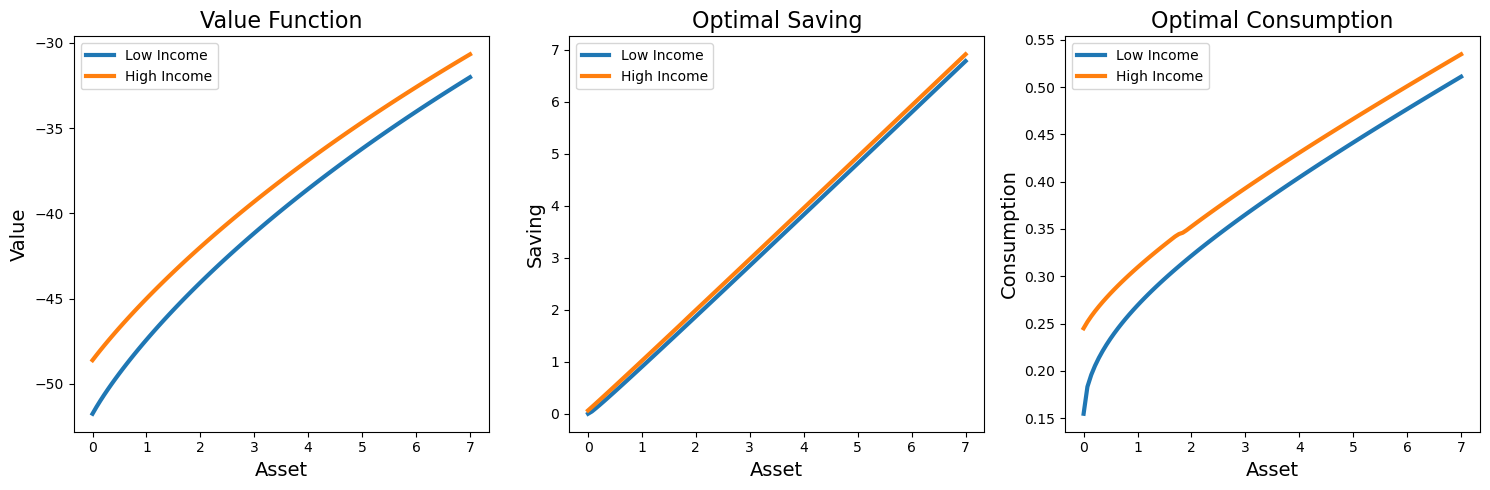

In [9]:
# Plot the graph
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(num_params.agrid, V_star[:, 0], label='Low Income', linewidth=3)
axs[0].plot(num_params.agrid, V_star[:, 1], label='High Income', linewidth=3)
axs[0].set_xlabel('Asset', fontsize=14)
axs[0].set_ylabel('Value', fontsize=14)
axs[0].set_title('Value Function', fontsize=16)
axs[0].legend()

axs[1].plot(num_params.agrid, saving[:, 0], label='Low Income', linewidth=3)
axs[1].plot(num_params.agrid, saving[:, 1], label='High Income', linewidth=3)
axs[1].set_xlabel('Asset', fontsize=14)
axs[1].set_ylabel('Saving', fontsize=14)
axs[1].set_title('Optimal Saving', fontsize=16)
axs[1].legend()

axs[2].plot(num_params.agrid, consumption[:, 0], label='Low Income', linewidth=3)
axs[2].plot(num_params.agrid, consumption[:, 1], label='High Income', linewidth=3)
axs[2].set_xlabel('Asset', fontsize=14)
axs[2].set_ylabel('Consumption', fontsize=14)
axs[2].set_title('Optimal Consumption', fontsize=16)
axs[2].legend()

plt.tight_layout()
plt.show()

#### Compute stationary distribution for given policies

In [10]:
# Define a function to compute stationary equilibrium
def KFE_Distribution(A_mat, num_params):

    # Assign a positive value to avoid singularity
    b = np.zeros((2*num_params.agridsize, 1))
    b[0] = 0.1

    # Modify corresponding row of A' matrix
    row = np.zeros((1, 2*num_params.agridsize))
    row[0][0] = 1
    A_transpose = np.transpose(A_mat)
    A_transpose[0, :] = row
    A_transpose = sp.csr_matrix(np.transpose(A_mat))

    # Compute the solution
    g = sp.linalg.spsolve(A_transpose, b)
    g_sum = np.dot(g, np.ones(2*num_params.agridsize)) * num_params.gridstep
    g = g/g_sum # normalize
    g = np.vstack([g[0:num_params.agridsize], g[num_params.agridsize:]]).T
    return g

In [11]:
# Solve
g = KFE_Distribution(A_mat, num_params)

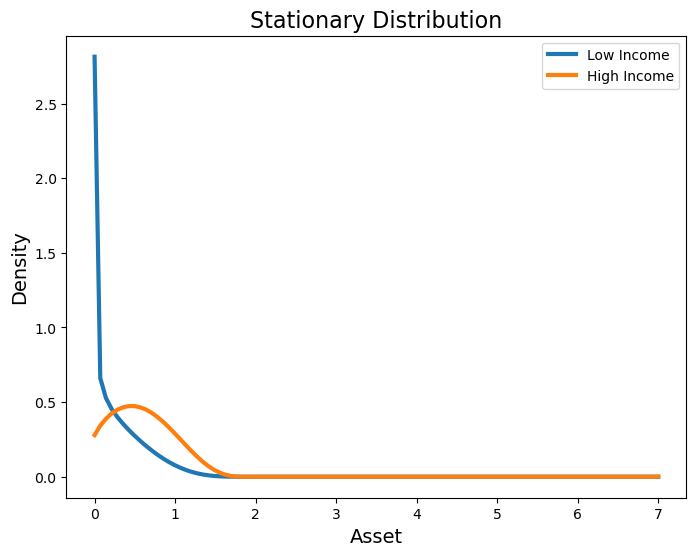

In [12]:
# Plot the graph
plt.figure(figsize=(8, 6))
plt.plot(num_params.agrid, g[:, 0], label='Low Income', linewidth=3)
plt.plot(num_params.agrid, g[:, 1], label='High Income', linewidth=3)
plt.xlabel('Asset', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Stationary Distribution', fontsize=16)
plt.legend()
plt.show()

#### Replicate the Figure IIb

In [13]:
# Define a function to compute capital supply and demand for given prices
def Compute_capitals(r, params, num_params, fix_wage=False, fixed_wage=None):

    # Solve HH problem
    V_0 = np.linspace(0, 1, num_params.agridsize)
    V_0 = np.column_stack((V_0, V_0))
    _, _, saving, A_mat = HJB_Iteration(r, V_0, params, num_params, progress=False, fix_wage=fix_wage, fixed_wage=fixed_wage)

    # Compute stationary equilibrium
    g = KFE_Distribution(A_mat, num_params)

    # Compute capital demand
    K_demand = (params.Z*params.alpha/(r+params.delta))**(1/(1-params.alpha)) * np.sum(g * params.e * num_params.gridstep)
    K_supply = np.sum(g * saving * num_params.gridstep)

    return K_demand, K_supply

In [14]:
r_vectors = np.linspace(-0.02, 0.0295, 10)
K_demands = np.zeros(10)
K_supplys = np.zeros(10)
for idx, r in enumerate(r_vectors):
    K_demand, K_supply = Compute_capitals(r, params, num_params)
    K_demands[idx] = K_demand
    K_supplys[idx] = K_supply

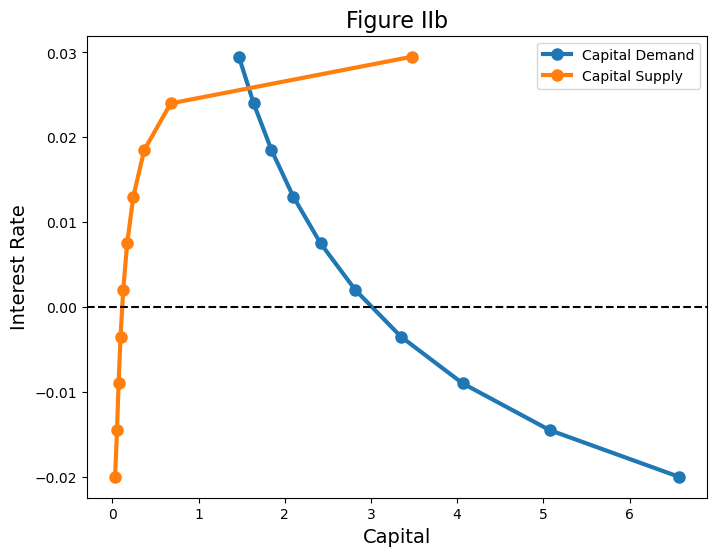

In [15]:
# Plot the graph
plt.figure(figsize=(8, 6))
plt.plot(K_demands, r_vectors, label = 'Capital Demand', linewidth=3, marker='o', markersize=8)
plt.plot(K_supplys, r_vectors, label = 'Capital Supply', linewidth=3, marker='o', markersize=8)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Capital', fontsize=14)
plt.ylabel('Interest Rate', fontsize=14)
plt.title('Figure IIb', fontsize=16)
plt.legend()
plt.show()

#### Find equilibrium interest rate

In [16]:
# Define a function to compute excess capital
def Compute_excess_capital(r, params=params, num_params=num_params, fix_wage=False, fixed_wage=None):

    K_demand, K_supply = Compute_capitals(r, params, num_params, fix_wage=fix_wage, fixed_wage=fixed_wage)
    excess_demand = K_demand - K_supply
    return excess_demand

In [17]:
# Define a function for the Newton-Rapshon
def Newton_Raphson(Obj, initial_guess, max_iter=100, tol=1e-6, eps=1e-10, fix_wage=False, fixed_wage=None):

    # Check initial guess
    if np.abs(Obj(initial_guess, fix_wage=fix_wage, fixed_wage=fixed_wage)) < tol:
        return initial_guess

    x_old = initial_guess
    for iter in range(max_iter):
        slope = (Obj(x_old+eps, fix_wage=fix_wage, fixed_wage=fixed_wage) - Obj(x_old, fix_wage=fix_wage, fixed_wage=fixed_wage)) / eps
        x_new = x_old - Obj(x_old, fix_wage=fix_wage, fixed_wage=fixed_wage) / slope

        # Check convergence & update
        if np.abs(x_new - x_old) < tol:
            return x_new
        else:
            x_old = x_new
    
    if iter == max_iter - 1:
        print("Newton_Raphson Error: No convergence")

In [18]:
r_eqm = Newton_Raphson(Compute_excess_capital, 0.025)
w_eqm = (1-params.alpha)*(params.Z*params.alpha/(r_eqm+params.delta))**(params.alpha/(1-params.alpha))
r_eqm, w_eqm

(0.027702137337034985, 1.4617419373883898)

---

### Task 2: Instrument approach

In [19]:
Z_vec = np.arange(0.1, 1.02, 0.02); Z_vec = Z_vec[::-1]
r_mat = np.zeros((len(Z_vec), 2))
K_mat = np.zeros((len(Z_vec), 2))
r_ge = r_eqm; r_pe = r_eqm

# Iterate over Zs
for Zidx, Z_value in enumerate(Z_vec):
    params.Z = Z_value
    # Without fixing wage
    r_ge = Newton_Raphson(Compute_excess_capital, r_ge)
    K_demand, K_supply = Compute_capitals(r_ge, params, num_params)
    r_mat[Zidx, 0] = r_ge
    K_mat[Zidx, 0] = K_demand
    # With fixing wage
    r_pe = Newton_Raphson(Compute_excess_capital, r_pe, fix_wage=True, fixed_wage=w_eqm)
    K_demand_pe, K_supply_pe = Compute_capitals(r_pe, params, num_params, fix_wage=True, fixed_wage=w_eqm)
    r_mat[Zidx, 1] = r_pe
    K_mat[Zidx, 1] = K_demand_pe

    print(f"Z interation in progress: Z = {Z_value:.2f}, r_ge = {r_ge:.6f}, K_ge = {K_demand:.6f}, r_pe = {r_pe:.6f}, K_pe = {K_demand_pe:.6f}, K_ge-K_pe = {K_demand-K_demand_pe:.6f}")

params.Z = 1.0 # back to default

Z interation in progress: Z = 1.00, r_ge = 0.027702, K_ge = 1.519440, r_pe = 0.027702, K_pe = 1.519440, K_ge-K_pe = 0.000000
Z interation in progress: Z = 0.98, r_ge = 0.027646, K_ge = 1.474591, r_pe = 0.027620, K_pe = 1.475353, K_ge-K_pe = -0.000761
Z interation in progress: Z = 0.96, r_ge = 0.027587, K_ge = 1.430212, r_pe = 0.027533, K_pe = 1.431747, K_ge-K_pe = -0.001536
Z interation in progress: Z = 0.94, r_ge = 0.027526, K_ge = 1.386309, r_pe = 0.027441, K_pe = 1.388631, K_ge-K_pe = -0.002322
Z interation in progress: Z = 0.92, r_ge = 0.027462, K_ge = 1.342889, r_pe = 0.027345, K_pe = 1.346010, K_ge-K_pe = -0.003121
Z interation in progress: Z = 0.90, r_ge = 0.027396, K_ge = 1.299958, r_pe = 0.027244, K_pe = 1.303890, K_ge-K_pe = -0.003932
Z interation in progress: Z = 0.88, r_ge = 0.027326, K_ge = 1.257520, r_pe = 0.027136, K_pe = 1.262276, K_ge-K_pe = -0.004756
Z interation in progress: Z = 0.86, r_ge = 0.027253, K_ge = 1.215583, r_pe = 0.027023, K_pe = 1.221175, K_ge-K_pe = -0.

In [20]:
rho_vec = np.array((0.02, 0.03, 0.04, 0.06, 0.08, 0.1))
r_vec = np.zeros(len(rho_vec))
K_vec = np.zeros(len(rho_vec))

# Iterate over rhos
for rho_idx, rho_value in enumerate(rho_vec):
    params.rho = rho_value
    r_new = Newton_Raphson(Compute_excess_capital, rho_value-0.005)
    K_demand, K_supply = Compute_capitals(r_new, params, num_params)
    r_vec[rho_idx] = r_new
    K_vec[rho_idx] = K_demand

    print(f"rho interation in progress: rho = {rho_value:.2f}, r_new = {r_new:.6f}, K = {K_demand:.6f}")

params.rho = 0.03 # back to default

rho interation in progress: rho = 0.02, r_new = 0.018319, K = 1.852127
rho interation in progress: rho = 0.03, r_new = 0.027702, K = 1.519440
rho interation in progress: rho = 0.04, r_new = 0.037104, K = 1.274592
rho interation in progress: rho = 0.06, r_new = 0.055955, K = 0.942904
rho interation in progress: rho = 0.08, r_new = 0.074889, K = 0.732180
rho interation in progress: rho = 0.10, r_new = 0.093921, K = 0.588639


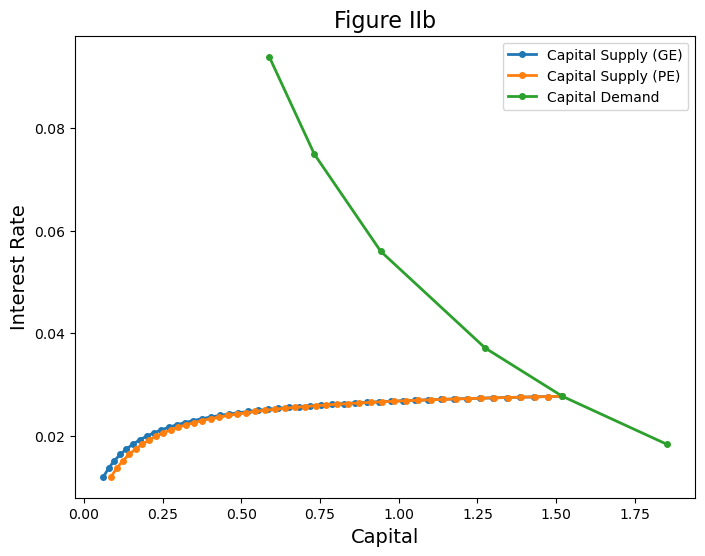

In [21]:
# Plot the graph
plt.figure(figsize=(8, 6))
plt.plot(K_mat[:, 0], r_mat[:, 0], label = 'Capital Supply (GE)', linewidth=2, marker='o', markersize=4)
plt.plot(K_mat[:, 1], r_mat[:, 0], label = 'Capital Supply (PE)', linewidth=2, marker='o', markersize=4)
plt.plot(K_vec, r_vec, label = 'Capital Demand', linewidth=2, marker='o', markersize=4)
plt.xlabel('Capital', fontsize=14)
plt.ylabel('Interest Rate', fontsize=14)
plt.title('Figure IIb', fontsize=16)
plt.legend()
plt.show()

---

### Homework: Solve heterogeneous return case

In [22]:
# Solve new equilbrium interest rate
params.income_mult = np.array((0.95, 1.05))
r_new = Newton_Raphson(Compute_excess_capital, 0.025)
r_new

0.027589208024535405

HJB_Iteration in progress: iter 0, error 0.9315715659229572
HJB_Iteration in progress: iter 100, error 0.17025247826680356
HJB_Iteration in progress: iter 200, error 0.03801106522810471
HJB_Iteration in progress: iter 300, error 0.00853810040606362
HJB_Iteration in progress: iter 400, error 0.0019219522137348122
HJB_Iteration in progress: iter 500, error 0.000433079728146879
HJB_Iteration in progress: iter 600, error 9.764089313080149e-05
HJB_Iteration in progress: iter 700, error 2.202072838741742e-05
HJB_Iteration in progress: iter 800, error 4.967194875860059e-06
HJB_Iteration in progress: iter 900, error 1.1205668428715398e-06
HJB_Iteration done: 908 iter, 0.58 seconds


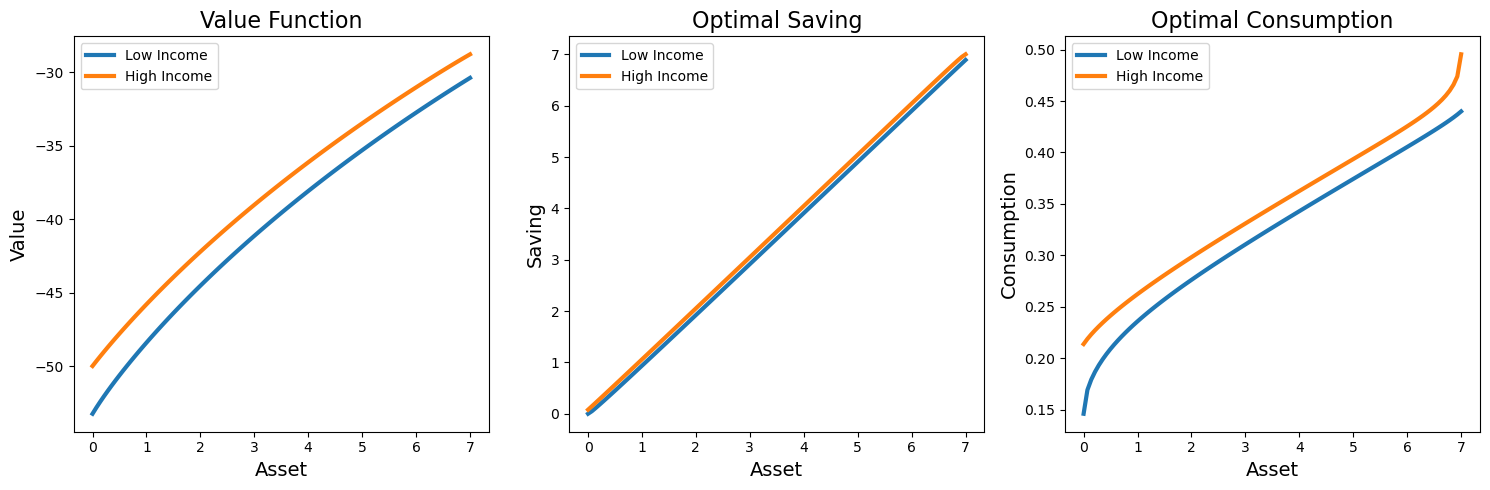

In [23]:
# Plot policy functions
r = r_new
V_0 = np.linspace(0, 1, num_params.agridsize)
V_0 = np.column_stack((V_0, V_0))
V_star, consumption, saving, A_mat = HJB_Iteration(r, V_0, params, num_params)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(num_params.agrid, V_star[:, 0], label='Low Income', linewidth=3)
axs[0].plot(num_params.agrid, V_star[:, 1], label='High Income', linewidth=3)
axs[0].set_xlabel('Asset', fontsize=14)
axs[0].set_ylabel('Value', fontsize=14)
axs[0].set_title('Value Function', fontsize=16)
axs[0].legend()

axs[1].plot(num_params.agrid, saving[:, 0], label='Low Income', linewidth=3)
axs[1].plot(num_params.agrid, saving[:, 1], label='High Income', linewidth=3)
axs[1].set_xlabel('Asset', fontsize=14)
axs[1].set_ylabel('Saving', fontsize=14)
axs[1].set_title('Optimal Saving', fontsize=16)
axs[1].legend()

axs[2].plot(num_params.agrid, consumption[:, 0], label='Low Income', linewidth=3)
axs[2].plot(num_params.agrid, consumption[:, 1], label='High Income', linewidth=3)
axs[2].set_xlabel('Asset', fontsize=14)
axs[2].set_ylabel('Consumption', fontsize=14)
axs[2].set_title('Optimal Consumption', fontsize=16)
axs[2].legend()

plt.tight_layout()
plt.show()

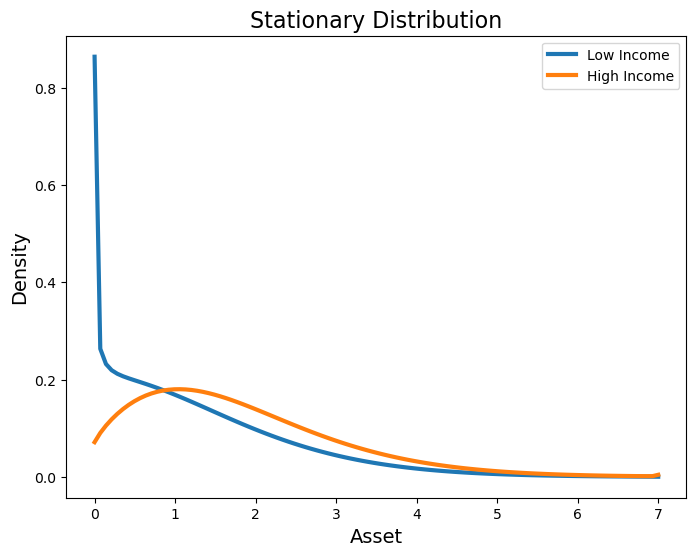

In [24]:
# Plot stationary distriobution

g = KFE_Distribution(A_mat, num_params)

plt.figure(figsize=(8, 6))
plt.plot(num_params.agrid, g[:, 0], label='Low Income', linewidth=3)
plt.plot(num_params.agrid, g[:, 1], label='High Income', linewidth=3)
plt.xlabel('Asset', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Stationary Distribution', fontsize=16)
plt.legend()
plt.show()